# Clustering con DBSCAN en Spark

# Contexto (el texto es de GPT, lo dejo ah√≠ para tomar ideas)

El algoritmo DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es especialmente √∫til cuando se desea identificar agrupaciones naturales en los datos sin asumir un n√∫mero predeterminado de clusters y siendo robusto frente a ruido o valores at√≠picos. En el contexto de un dataset de canciones de Spotify, que contiene atributos como danceability, energy, valence, tempo, loudness, acousticness, instrumentalness, entre otros, DBSCAN puede ofrecer ventajas significativas para tareas de an√°lisis musical y recomendaciones.

Posibles aplicaciones del clustering con DBSCAN en Spotify:

    Descubrimiento de g√©neros o subg√©neros emergentes
    DBSCAN puede identificar grupos densos de canciones con caracter√≠sticas similares que no encajan bien en los g√©neros tradicionales. Esto permite detectar subg√©neros o estilos musicales emergentes que a√∫n no est√°n bien definidos.

    Agrupamiento de canciones similares para sistemas de recomendaci√≥n
    En lugar de basarse solo en colaborative filtering o clasificaci√≥n supervisada, DBSCAN permite crear clusters de canciones similares en base puramente a sus caracter√≠sticas sonoras. Esto facilita recomendaciones m√°s personalizadas y con base en el contenido musical real.

    Segmentaci√≥n de playlists o an√°lisis de tendencias musicales
    Se pueden analizar las playlists populares y agrupar canciones seg√∫n su perfil ac√∫stico, revelando patrones dentro de g√©neros, subg√©neros o estados de √°nimo predominantes en diferentes momentos del tiempo.

    Identificaci√≥n de canciones "outliers" o √∫nicas
    Dado que DBSCAN clasifica algunos puntos como ruido, esto permite detectar canciones que se alejan notablemente de cualquier agrupaci√≥n densa, lo cual puede ser √∫til para:

        Detectar m√∫sica experimental.

        Identificar "joyas ocultas" con caracter√≠sticas inusuales.

        Filtrar outliers en an√°lisis estad√≠sticos.

Inter√©s de una implementaci√≥n paralela de DBSCAN en este contexto

El dataset de Spotify puede contener millones de canciones, lo que hace que una implementaci√≥n secuencial de DBSCAN sea poco escalable debido a su alto coste computacional en el c√°lculo de distancias entre puntos. Una versi√≥n paralela distribuida con Apache Spark permite:

    Procesar grandes vol√∫menes de datos musicales en cl√∫steres de computaci√≥n.

    Reducir dr√°sticamente el tiempo de ejecuci√≥n al dividir el espacio musical en particiones.

    Mantener la precisi√≥n del algoritmo adaptando particiones con solapamiento (por el valor de eps) para no perder conexiones entre canciones similares en distintas regiones del espacio.

# Objetivos

# Descripci√≥n del algoritmo

## Clustering

https://towardsdatascience.com/an-efficient-implementation-of-dbscan-on-pyspark-3e2be646f57d/

In [1]:
import os
import math
import numpy as np
import pyspark.sql.functions as sql_f

from graphframes import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from scipy.spatial import distance
from pyspark.sql.functions import col, substring
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import substring
from pyspark.sql.functions import size, col
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import Row
from itertools import combinations

# Variable de entorno. Modificar en caso de disponer de varias
# versiones de Java instaladas.
os.environ["JAVA_HOME"] = r"/home/cristhian/Descargas/OpenJDK8U-jdk_x64_linux_hotspot_8u452b09/jdk8u452-b09"

In [2]:
# Definici√≥n del entorno de ejecuci√≥n
CORES = 12 # N√∫mero de n√∫cleos de CPU a usar
PARTS = 12 # N√∫mero de particiones del dataset (para hacer repartition)
FRAC = 0.5 # Fracci√≥n de los datos aleatoriamente seleccionados
DIMS = 14  # N√∫mero de componentes PCA seleccionadas en base a mayor varianza explicada

spark = (
    SparkSession.builder.master(f"local[{CORES}]")
    .appName(f"Local DT con {CORES} particiones")
    .config("spark.driver.memory", "24g")
    .config("spark.executor.memory", "24g")
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12")

    .getOrCreate()
)
sc = spark.sparkContext
sc.setCheckpointDir("/tmp/graphframes-checkpoints")

:: loading settings :: url = jar:file:/home/cristhian/anaconda3/envs/BD_Spark/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/cristhian/.ivy2/cache
The jars for the packages stored in: /home/cristhian/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c19bd1fd-2e62-4b8a-9a7c-82996432aabf;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 80ms :: artifacts dl 2ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	----------------------------

## An√°lisis

Explicar muy bien que podemos hacer el EDA con sklearn, ya que en principio (en la mayor√≠a de dataset para Big Data) deber√≠amos hacer un sampling para poder hacerlo.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("spotify_songs.csv")

print("Tama√±o: ", data.shape)
print(data.head())

Tama√±o:  (32833, 23)
                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_album_release_date  \
0  I Don't Care (with Jus

In [4]:
print("Variables y sus tipos")
print(data.info())

Variables y sus tipos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-nul

In [5]:
print("Resumen estadiÃÅstico:")
print(data.describe())

Resumen estadiÃÅstico:
       track_popularity  danceability        energy           key  \
count      32833.000000  32833.000000  32833.000000  32833.000000   
mean          42.477081      0.654850      0.698619      5.374471   
std           24.984074      0.145085      0.180910      3.611657   
min            0.000000      0.000000      0.000175      0.000000   
25%           24.000000      0.563000      0.581000      2.000000   
50%           45.000000      0.672000      0.721000      6.000000   
75%           62.000000      0.761000      0.840000      9.000000   
max          100.000000      0.983000      1.000000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  32833.000000  32833.000000  32833.000000  32833.000000   
mean      -6.719499      0.565711      0.107068      0.175334   
std        2.988436      0.495671      0.101314      0.219633   
min      -46.448000      0.000000      0.000000      0.000000   
25%       -8.171000      0.000

In [6]:
print("N√∫mero de valores nulos:")
print(data.isnull().sum())

N√∫mero de valores nulos:
track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64


Distribuci√≥n variables num√©ricas:


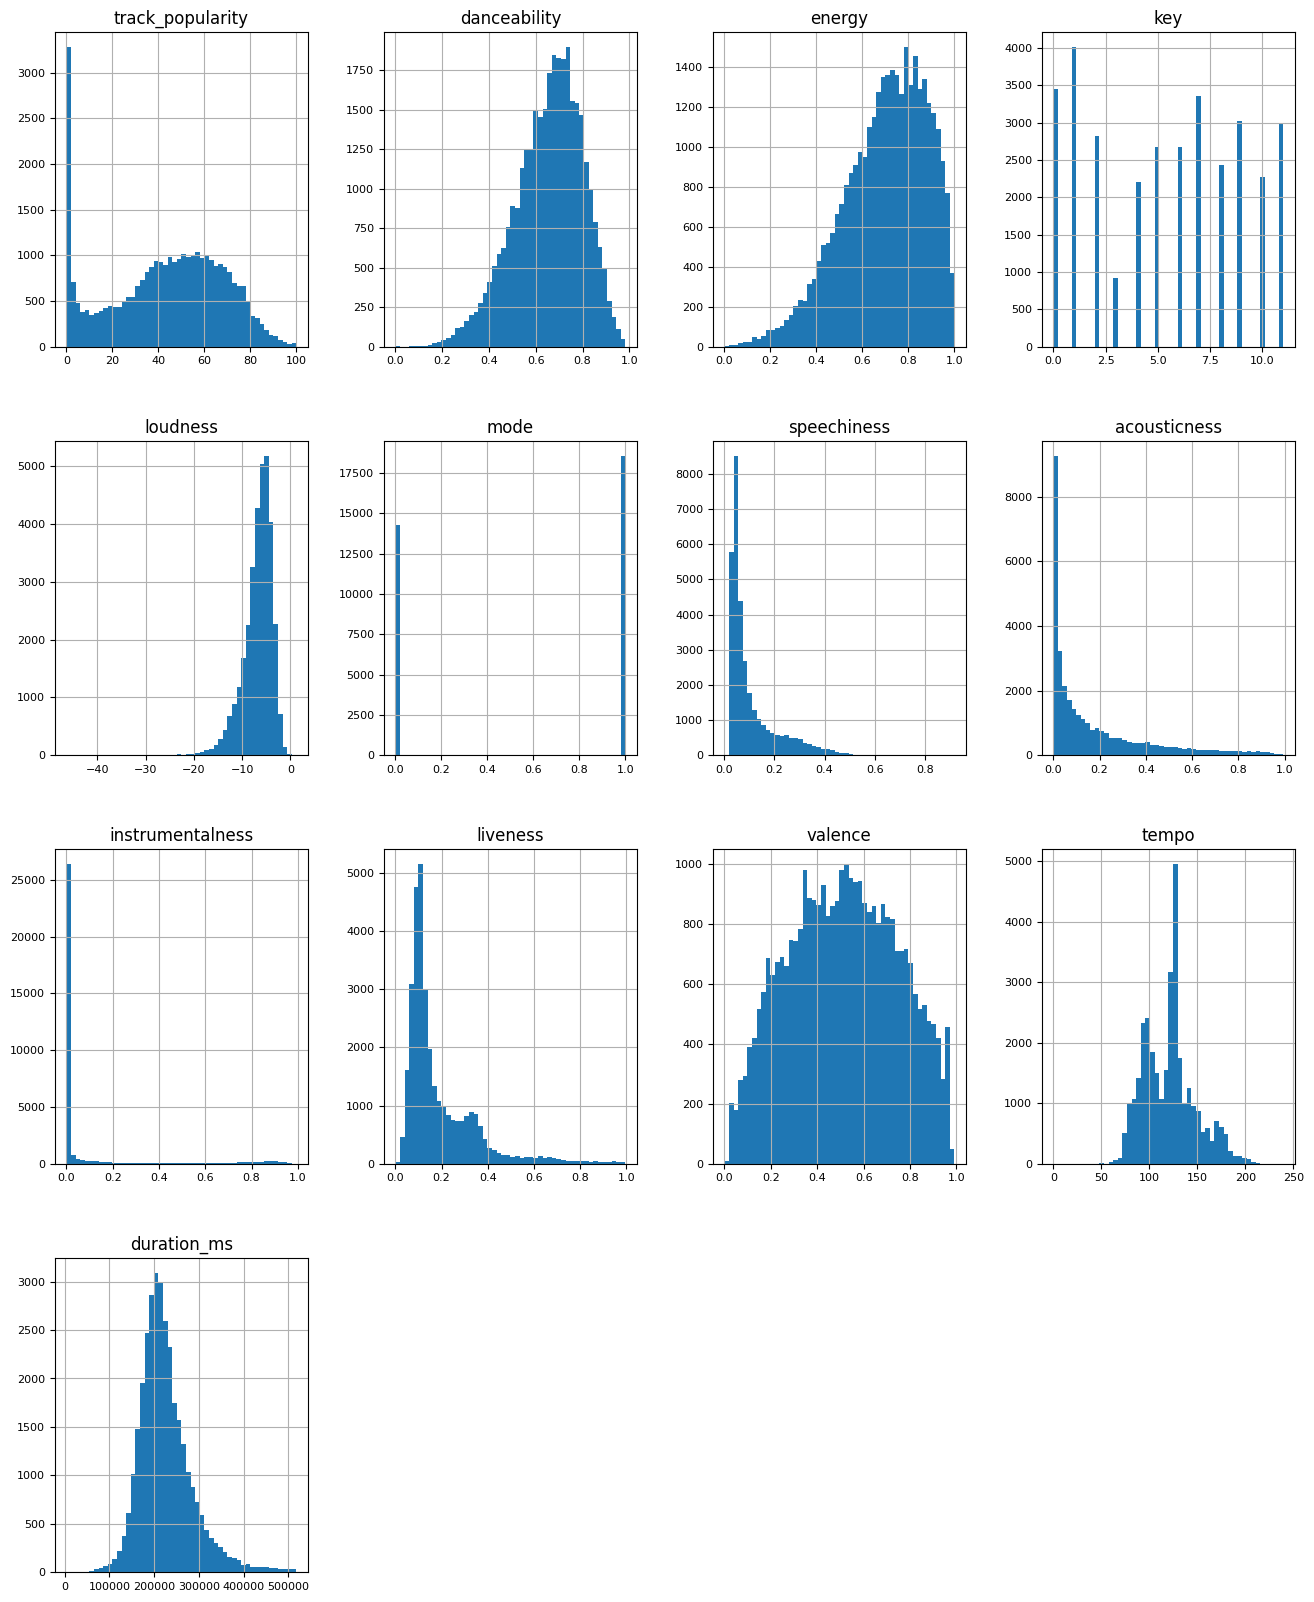

In [7]:
print("Distribuci√≥n variables num√©ricas:")
data_num = data.select_dtypes(include = ['int64', 'float64'])
data_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

In [8]:
print("Variables categoÃÅricas:")
data_cat = data.select_dtypes(include = ['object'])
print(data_cat.columns)

Variables categoÃÅricas:
Index(['track_id', 'track_name', 'track_artist', 'track_album_id',
       'track_album_name', 'track_album_release_date', 'playlist_name',
       'playlist_id', 'playlist_genre', 'playlist_subgenre'],
      dtype='object')


playlist_genre
edm      6043
latin    5155
pop      5507
r&b      5431
rap      5746
rock     4951
dtype: int64
playlist_genre  playlist_subgenre        
edm             big room                     1206
                electro house                1511
                pop edm                      1517
                progressive electro house    1809
latin           latin hip hop                1656
                latin pop                    1262
                reggaeton                     949
                tropical                     1288
pop             dance pop                    1298
                electropop                   1408
                indie poptimism              1672
                post-teen pop                1129
r&b             hip pop                      1256
                neo soul                     1637
                new jack swing               1133
                urban contemporary           1405
rap             gangster rap                 1

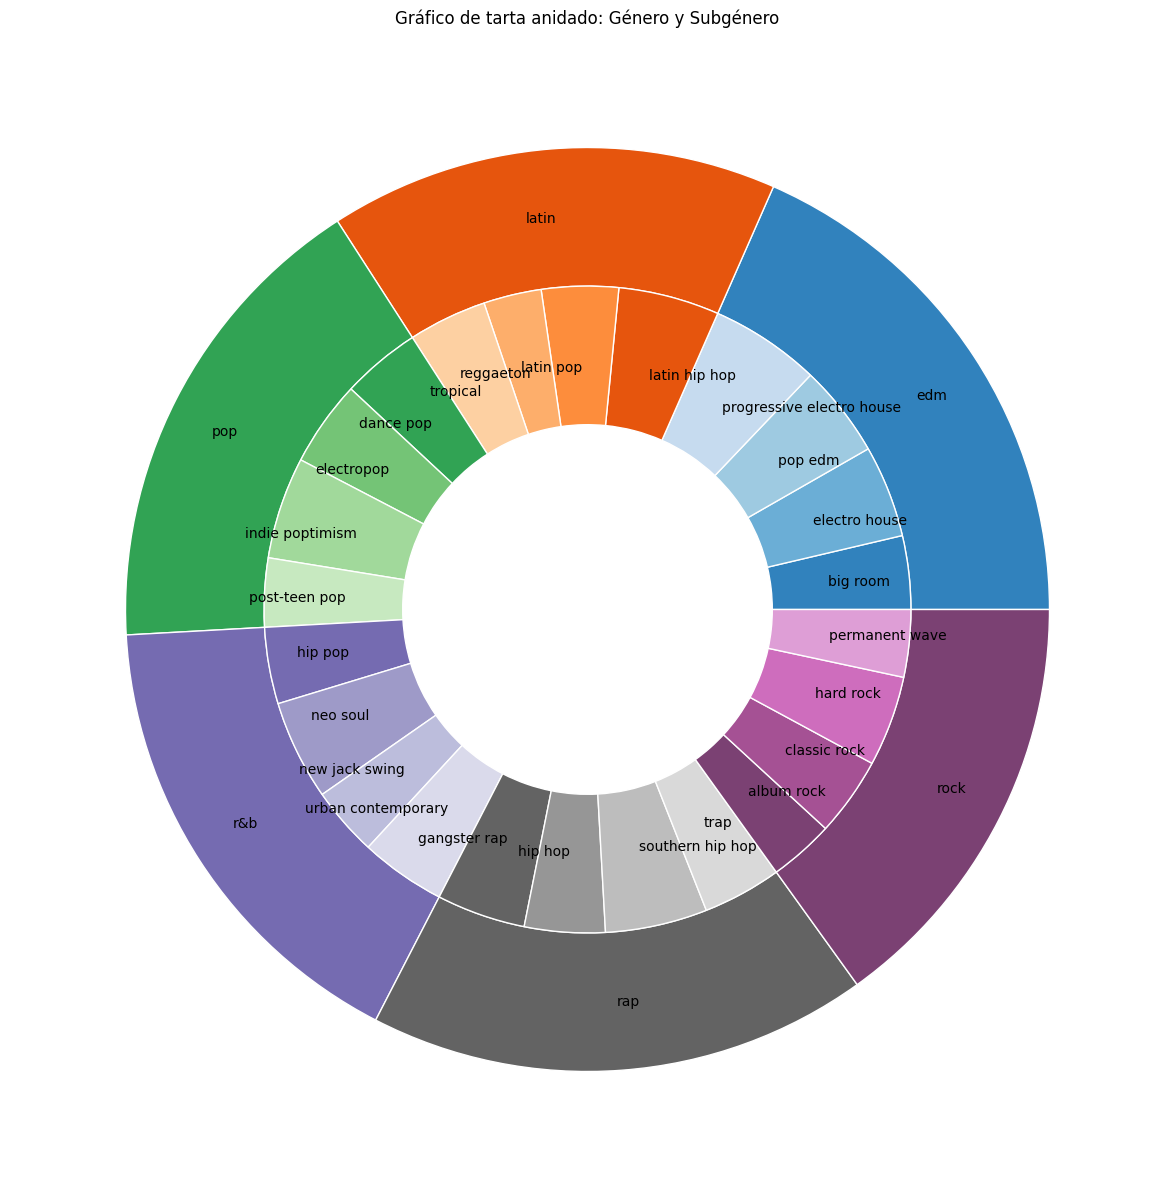

In [9]:
# 1. Agrupar por 'playlist_genre' para la capa externa y contar la cantidad de registros por g√©nero.
outer_data = data.groupby('playlist_genre').size()
print(outer_data)

# 2. Agrupar por ambas variables para la capa interna y contar la cantidad de registros por cada combinaci√≥n de g√©nero y subg√©nero.
inner_data = data.groupby(['playlist_genre', 'playlist_subgenre']).size()
print(inner_data)

# Preparar los datos para el gr√°fico:
# Etiquetas y tama√±os para la tarta externa (por g√©neros)
outer_labels = outer_data.index.tolist()
outer_sizes = outer_data.values.tolist()

# Para la tarta interna (por subg√©neros) se requiere mantener el orden para asignar colores coherentes.
inner_labels = []
inner_sizes = []
# Definiremos una lista de colores para la tarta interna basados en un colormap.
colors_inner = []

# Usamos un colormap de matplotlib  para obtener colores diferenciados.
cmap = plt.get_cmap('tab20c')
cmap2 = plt.get_cmap('tab20b')
# Para la asignaci√≥n de colores, definimos un √≠ndice que se ir√° incrementando a medida que agregamos subcategor√≠as.
color_idx = 0

# Recorremos cada g√©nero para extraer sus subg√©neros
for genre in outer_labels:
    # Seleccionar los datos del g√©nero actual
    sub_data = inner_data[genre]
    # Agregar las etiquetas de subg√©nero y sus cantidades
    for subgenre, count in sub_data.items():
        inner_labels.append(subgenre)
        inner_sizes.append(count)
        # Asignar un color del colormap (se puede ajustar la estrategia de asignaci√≥n si se desea)
        if (color_idx < 20):
            colors_inner.append(cmap(color_idx))
        else:
            colors_inner.append(cmap2(color_idx-4))
        color_idx += 1
# Crear el gr√°fico
fig, ax = plt.subplots(figsize=(15, 15))

colors_outer = [cmap(i*4) for i in range(5)]
colors_outer.append(colors_inner[-4])
print(colors_outer)
# Capa externa: gr√°fico de tarta de g√©neros.
# Usamos 'wedgeprops' para definir el ancho de las "donut slices".
ax.pie(outer_sizes, radius=1, labels=outer_labels, labeldistance=0.85,
       colors=colors_outer, wedgeprops=dict(width=0.3, edgecolor='white'))

# Capa interna: gr√°fico de tarta de subg√©neros.
# Se dibuja sobre la capa externa.
ax.pie(inner_sizes, radius=1-0.3, labels=inner_labels, labeldistance=0.75,
       colors=colors_inner, wedgeprops=dict(width=0.3, edgecolor='white'))

# Asegurar que el gr√°fico tiene relaci√≥n de aspecto 1:1 para que sea circular.
ax.set(aspect="equal")
plt.title("Gr√°fico de tarta anidado: G√©nero y Subg√©nero")
plt.show()

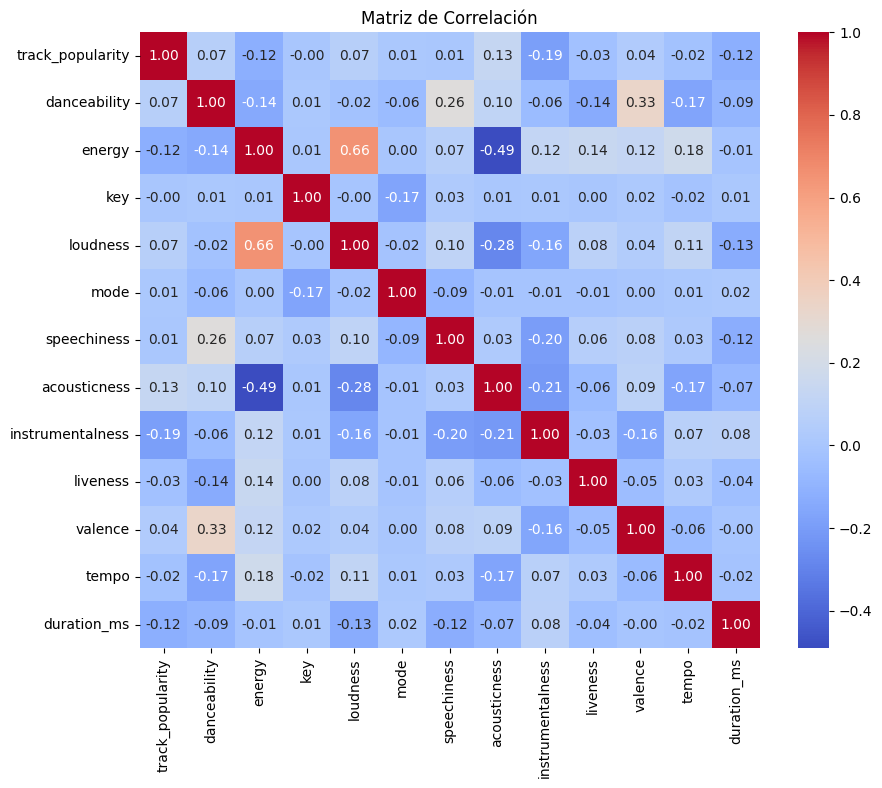

In [10]:
# Spearman
corr_matrix = data_num.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlaci√≥n")
plt.show()

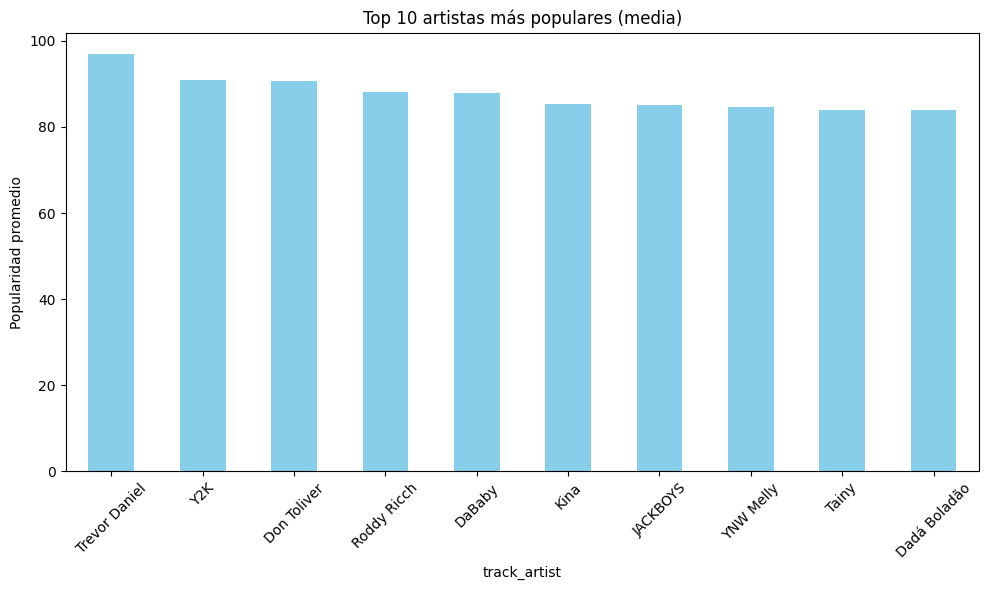

In [11]:
top_artistas = data.groupby('track_artist')['track_popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_artistas.plot(kind='bar', color='skyblue')
plt.title('Top 10 artistas m√°s populares (media)')
plt.ylabel('Popularidad promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

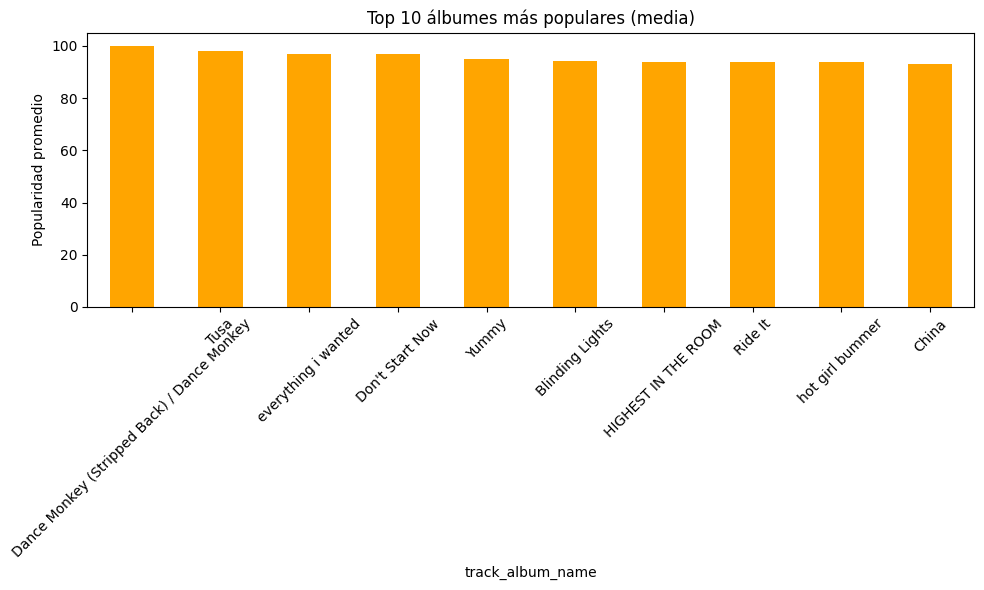

In [12]:
top_albums = data.groupby('track_album_name')['track_popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_albums.plot(kind='bar', color='orange')
plt.title('Top 10 √°lbumes m√°s populares (media)')
plt.ylabel('Popularidad promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


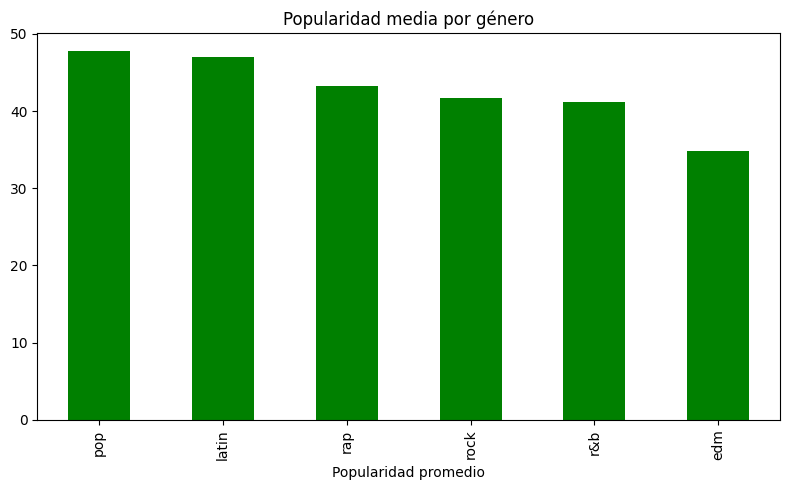

In [13]:
top_generos = data.groupby('playlist_genre')['track_popularity'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
top_generos.plot(kind='bar', color='green')
plt.title('Popularidad media por g√©nero')
plt.xlabel('Popularidad promedio')
plt.tight_layout()
plt.show()


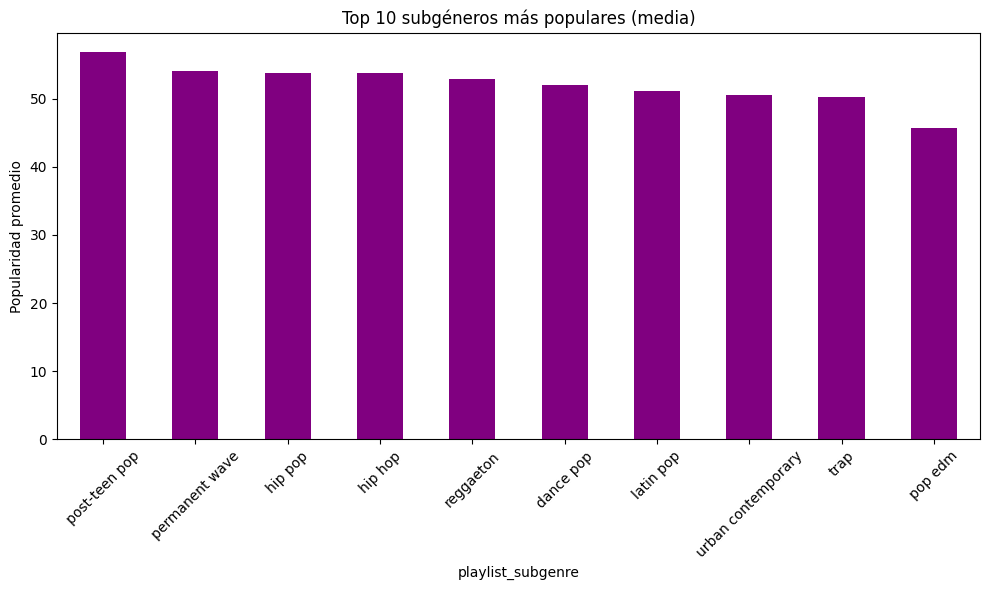

In [14]:
top_subgeneros = data.groupby('playlist_subgenre')['track_popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_subgeneros.plot(kind='bar', color='purple')
plt.title('Top 10 subg√©neros m√°s populares (media)')
plt.ylabel('Popularidad promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Carga de datos con Spark

Tras realizar un an√°lisis exploratorio de datos con Pandas y  librer√≠as est√°ndar para el visualizado, pasamos a trabajar en la problem√°tica de Big Data que tiene el problema, comenzamos desde este punto a usar la tecnolog√≠a Spark.

Comenzamos leyendo el conjunto de datos desde el archivo en formato csv que tenemos. Utilizando la funci√≥n read() y algunas de sus funciones internas podemos especificar el formato de origen del archivo, si queremos que se incluya la cabecera o no (en nuestro caso, la incluiremos), el delimitador que existe en el archivo original para dividir los diferentes valores de un individuo (en nuestro caso, una coma), cargamos el archivo y con repartition indicamos a Spark, en la cantidad de particiones que queremos que distribuya los datos.

In [15]:
df = spark.read.format('csv') \
    .option('header', 'true') \
    .option('delimiter', ',') \
    .load('spotify_songs.csv') \
    .repartition(PARTS)

Mostramos los 10 primeros individuos del conjunto de datos. Observamos como la carga se ha completado, en principio, sin ning√∫n problema aparente ni en los individuos ni en los atributos.

In [16]:
df.show(10, truncate=False) 

+----------------------+--------------------------------------+---------------------+----------------+----------------------+--------------------------------------+------------------------+--------------------------------------------------+----------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|track_id              |track_name                            |track_artist         |track_popularity|track_album_id        |track_album_name                      |track_album_release_date|playlist_name                                     |playlist_id           |playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|
+----------------------+--------------------------------------+---------------------+----------------+----------------------+--------------------------------------+--------

Mostramos los nombres de los atributos y su tipo, imprimiendo el esquema del dataframe. Observamos como por defecto todos los atributos se cargan con tipo de dato String. Ser√° necesaria m√°s tarde una conversi√≥n de alguno de ellos a un tipo num√©rico. 

In [17]:
df.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_popularity: string (nullable = true)
 |-- track_album_id: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- track_album_release_date: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- duration_ms: string (nullable = true)



A modo de comprobaci√≥n, tras observar en el EDA los valores √∫nicos de ciertas variables, comprobamos si se siguen cumpliendo tras la lectura de los datos en Spark.

In [18]:
df.select('playlist_genre').distinct().show()
print("N√∫mero de g√©neros √∫nicos:", df.select('playlist_genre').distinct().count())

+--------------------+
|      playlist_genre|
+--------------------+
|                 r&b|
|                 pop|
|                 edm|
|                 rap|
|                rock|
|               latin|
|1E5VdGGWkpDQ682gd...|
|4425cRh83Uzor4qCR...|
|5EMARioe9z9eKOeWI...|
|0JmBB9HfrzDiZoPVR...|
|48AzM7l4M02DBYd2N...|
| Matthias Heilbro...|
|6wyJ4bsjZaUKa9f6G...|
|37i9dQZF1DWTDafB3...|
+--------------------+

N√∫mero de g√©neros √∫nicos: 14


Observamos como tenemos para la variable playlist_genre algunos valores inesperados, tras revisar el conjunto de datos observamos algunos individuos en el conjuntos de datos que tienen valores err√≥neos. En la siguiente secci√≥n, el preprocesado, lidiamos con este problema. 

# Preprocesado

En esta secci√≥n llevamos a cabo el preprocesado del trabajo utilizando Spark. De forma resumida, en esta parte, realizamos las siguientes tareas: asignar los tipos correctos a las variables, filtrar algunos individuos para solucionar la existencia de individuos con valores corruptos, la eliminaci√≥n de variables con un valor √∫nico para cada individuo (variables identificadoras del individuo), aplicaci√≥n de one-hot encoding para permitir la inclusi√≥n de variables categ√≥ricas y la aplicaci√≥n de reducci√≥n de dimensionalidad via PCA. 

Importamos algunas dependencias generales para el trabajo.

In [19]:
# Dependencias generales
import matplotlib.pyplot as plt
import numpy as np


from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

## Asignaci√≥n de los tipos correctos de las variables 

Algunas variables como track_popularity (que mide la popularidad) y danceability (que mide c√≥mo de bailable es una canci√≥n) entre muchas otras, tienen una naturaleza num√©rica.  Para ello, definimos una lista con los nombres de las columnas del DataFrame df, de las cuales queremos convertir su tipo.  A partir de aqu√≠, realizamos un casting al tipo de dato DoubleType (n√∫meros decimales) mediante un bucle.

In [20]:
# Lista de columnas a convertir
cols_to_convert = [
    "track_popularity", "danceability", "energy", "key", "loudness", "mode",
    "speechiness", "acousticness", "instrumentalness", "liveness", "valence",
    "tempo", "duration_ms"
]

# Castea las columnas especificadas a DoubleType
for c in cols_to_convert:
    df = df.withColumn(c, col(c).cast(DoubleType()))

Observamos de nuevo el esquema de DataFrame donde ahora s√≠ comprobamos que est√°n las variables con su tipo correcto.

In [21]:
df.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_popularity: double (nullable = true)
 |-- track_album_id: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- track_album_release_date: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: double (nullable = true)



## Eliminaci√≥n de instancias corruptas

Tras el an√°lisis se han comprobado la existencia de ciertas instancias con valores corruptos en el conjunto de datos. Proponemos una soluci√≥n directa, que en el contexto de Big Data y nuestro dataset (que tiene una suficiente cantidad de individuos) vemos viable y razonable: la eliminaci√≥n directa. Para ello, se filtran √∫nicamente las instancias que cumplen con alguno de los posibles valores de la variable categ√≥rica: playlist_genre (vista en el an√°lisis). 

Utilizamos la construcci√≥n de una lista manual de los valores correctos y la funci√≥n filter() para su correcto filtrado.

In [22]:
from pyspark.sql.functions import col

valid_genres = ['pop', 'rock', 'rap', 'edm', 'r&b', 'latin']
df = df.filter(col('playlist_genre').isin(valid_genres))

In [23]:
df.select('playlist_genre').distinct().show()
print("N√∫mero de g√©neros √∫nicos:", df.select('playlist_genre').distinct().count())

+--------------+
|playlist_genre|
+--------------+
|           r&b|
|           pop|
|           edm|
|           rap|
|          rock|
|         latin|
+--------------+

N√∫mero de g√©neros √∫nicos: 6


A modo de comprobaci√≥n, mostramos y contamos los valores √∫nicos de esa variable para comprobar que ya no existen los valores err√≥neos que obten√≠amos antes. Ahora s√≠, tenemos los verdaderos valores y su verdadera cantidad. Como no hemos detectado ningunos otros valores err√≥neos, asumimos que se han filtrado el resto de valores correctamente, y ya tenemos el conjunto de datos limpio.

## Eliminaci√≥n de variables con valores √∫nicos 

Se eliminar√°n las variables que tienen un valor identificador para cada canci√≥n. Las variables como: track_id, track_name, track_artist, track_album_id, track_album_name, playlist_name y playlist_id son eliminadas en este apartado, porque act√∫an como identificadores √∫nicos y no aportan valor predictivo ni patrones √∫tiles al an√°lisis; al tener un valor distinto para cada fila, no permiten generalizaci√≥n, pueden introducir ruido y aumentar√≠an la complejidad del modelo sin beneficio real.

In [24]:
cols_to_drop = [
    'track_id', 'track_name', 'track_artist', 
    'track_album_id', 'track_album_name', 
    'playlist_name', 'playlist_id'
]

df = df.drop(*cols_to_drop)

## Inclusi√≥n de un ID propio

A pesar de haber eliminado las variables identificadoras como track_id o track_name, se incluir√° una variable id (de construcci√≥n propia) que no ser√° utilizada en el algoritmo de clustering, pero que servir√° como referencia para realizar visualizaciones pertinentes. Esta variable nos permitir√° vincular cada observaci√≥n con sus valores originales de las variables categ√≥ricas playlist_genre y playlist_subgenre, facilitando as√≠ la interpretaci√≥n y comparaci√≥n de los resultados obtenidos por el clustering con las categor√≠as iniciales de las playlists.

Para ello, utilizamos la funci√≥n monotonically_increasing_id. Esta funci√≥n genera valores enteros largos que aumentan de forma mon√≥tona, aunque no necesariamente consecutiva ni ordenada estrictamente, lo que garantiza unicidad sin necesidad de una columna de √≠ndice previamente definida. 

In [25]:
from pyspark.sql.functions import monotonically_increasing_id

# A√±adimos la ID al comienzo de la l√≠nea
df = df.withColumn("id", monotonically_increasing_id())

In [26]:
df.show()

+----------------+------------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+
|track_popularity|track_album_release_date|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms| id|
+----------------+------------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+
|            69.0|              2019-06-07|           rap|          hip hop|       0.951| 0.573|0.0|  -6.002| 0.0|      0.227|      0.0667|             0.0|   0.119|   0.42|105.052|   211040.0|  0|
|             0.0|              2013-09-20|           pop|       electropop|       0.723| 0.914|9.0|   -5.13| 0.0|     0.0409|      0.0862|           0.723|   0.231|  0.893|135.547|   220027.0|  1|
|         

## Aplicaci√≥n de one-hot enconding de las variables categ√≥ricas

Se aplicar√° one-hot enconding a las variables: playlist_genre, playlist_subgenre. Y a la variable: track_album_release_date se le aplica un one-hot encoding por decada.

In [27]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

def one_hot_preprocess(df, categorical_cols):

    indexers = [StringIndexer(inputCol=col, outputCol=col + '_idx', handleInvalid='keep') for col in categorical_cols]
    encoders = [OneHotEncoder(inputCol=col + '_idx', outputCol=col + '_ohe') for col in categorical_cols]

    pipeline = Pipeline(stages=indexers + encoders)
    return  pipeline.fit(df).transform(df)

In [28]:
categorical_cols = ['playlist_genre']
df = one_hot_preprocess(df, categorical_cols= categorical_cols)

In [29]:
df.select('playlist_genre', 'playlist_genre_ohe').show(10, truncate=False)

+--------------+------------------+
|playlist_genre|playlist_genre_ohe|
+--------------+------------------+
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
+--------------+------------------+
only showing top 10 rows



In [30]:
from pyspark.sql.functions import substring

# Extraer el a√±o de la fecha (formato 'YYYY-MM-DD')
df = df.withColumn("release_year", substring("track_album_release_date", 1, 4).cast("int")).cache()

In [31]:
# Guardamos las variables 'playlist_genre' y 'playlist_subgenre' en otro dataframe
# Nota: ser√°n √∫tiles m√°s tarde para comparar con los resultados del Clustering
df_var_saved = df.select('id', 'playlist_genre', 'playlist_subgenre')

print(df.show())

# Eliminaci√≥n de variables transformadas y retiradas
df = df.drop('playlist_genre', 'playlist_subgenre', 'track_album_release_date')

+----------------+------------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------------+------------+
|track_popularity|track_album_release_date|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms| id|playlist_genre_idx|playlist_genre_ohe|release_year|
+----------------+------------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------------+------------+
|            69.0|              2019-06-07|           rap|          hip hop|       0.951| 0.573|0.0|  -6.002| 0.0|      0.227|      0.0667|             0.0|   0.119|   0.42|105.052|   211040.0|  0|               1.0|     (6,[1],[1.0])|        2019|
|   

In [32]:
# Mostramos variables guardadas
df_var_saved.show(truncate=False)

+---+--------------+-----------------+
|id |playlist_genre|playlist_subgenre|
+---+--------------+-----------------+
|0  |rap           |hip hop          |
|1  |pop           |electropop       |
|2  |rock          |permanent wave   |
|3  |rock          |album rock       |
|4  |rock          |album rock       |
|5  |pop           |indie poptimism  |
|6  |pop           |post-teen pop    |
|7  |rock          |classic rock     |
|8  |rap           |hip hop          |
|9  |rap           |southern hip hop |
|10 |pop           |indie poptimism  |
|11 |pop           |dance pop        |
|12 |rap           |hip hop          |
|13 |rock          |album rock       |
|14 |rock          |album rock       |
|15 |pop           |electropop       |
|16 |pop           |indie poptimism  |
|17 |rap           |gangster rap     |
|18 |rock          |classic rock     |
|19 |pop           |indie poptimism  |
+---+--------------+-----------------+
only showing top 20 rows



In [33]:
idx_cols = [col + '_idx' for col in categorical_cols]
df = df.drop(*idx_cols)

In [34]:
df.show(20, truncate=False)

+----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+
|track_popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|id |playlist_genre_ohe|release_year|
+----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+
|69.0            |0.951       |0.573 |0.0|-6.002  |0.0 |0.227      |0.0667      |0.0             |0.119   |0.42   |105.052|211040.0   |0  |(6,[1],[1.0])     |2019        |
|0.0             |0.723       |0.914 |9.0|-5.13   |0.0 |0.0409     |0.0862      |0.723           |0.231   |0.893  |135.547|220027.0   |1  |(6,[2],[1.0])     |2013        |
|0.0             |0.681       |0.893 |0.0|-3.519  |1.0 |0.037      |0.178       |0.0             |0.213   |0.815  |123.651|205132.0   |2  |(

### Modificar la representaci√≥n de one-hot Sparse Vector a columnas convencionales 

Explicar muy bien porque hemos pensado en cierto punto de la implemetaci√≥n cambiar a columnas convencionales.

## Estandarizaci√≥n

In [35]:
columnas = df.columns

if "id" in columnas:
    columnas.remove("id")

In [36]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Ensamblar todas los atributos en un √∫nico vector dentro de una sola columna
assembler = VectorAssembler(inputCols=columnas, outputCol="features")
df = assembler.transform(df)

# Ajuste de la estandarizaci√≥n
scaler = StandardScaler(
    inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Eliminar la columna 'features'
df = df.drop('features')

df.show(20, truncate=False)

25/04/24 20:24:29 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|id |playlist_genre_ohe|release_year|scaled_features                                                                                                                                                                                                                                                 

## Aplicaci√≥n de reducci√≥n de la dimensionalidad

### An√°lisis de la varianza explicada de las componentes

In [37]:
from pyspark.ml.feature import PCA

# Obtener el tama√±o del vector en la columna 'features'
vector_size = df.select("scaled_features").first()[0].size

pca = PCA(k = vector_size, inputCol="scaled_features", outputCol="pca_features") 
pca_model = pca.fit(df)

25/04/24 20:24:30 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/24 20:24:30 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
25/04/24 20:24:31 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/04/24 20:24:31 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


[0.12425651 0.23617776 0.32277568 0.39915552 0.46728501 0.5270107
 0.58343955 0.63857329 0.68729757 0.73344538 0.77645893 0.81722258
 0.8578004  0.89051726 0.92105821 0.95006117 0.97077572 0.98966445
 1.         1.        ]


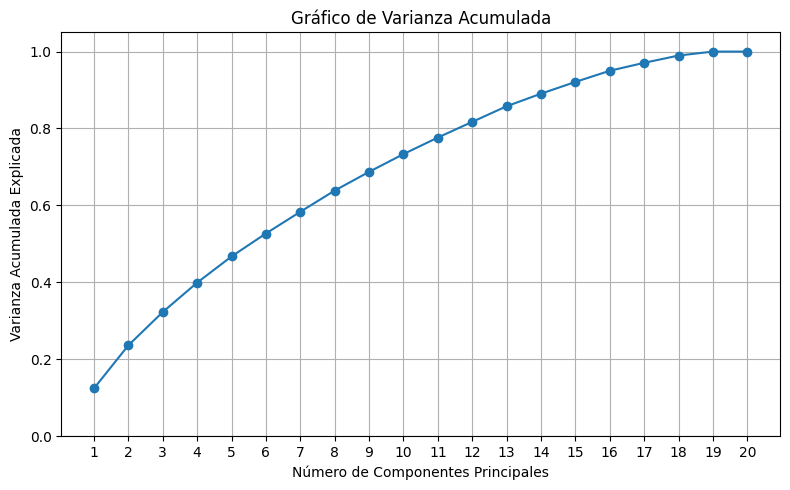

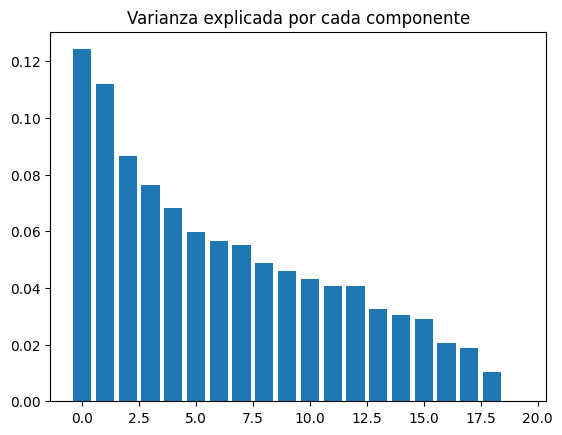

In [38]:
explained_variance = pca_model.explainedVariance.toArray()
cumulative_variance = np.cumsum(explained_variance)
print(cumulative_variance)

# Visualizar varianza acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('N√∫mero de Componentes Principales')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Gr√°fico de Varianza Acumulada')
plt.grid(True)
plt.ylim(0, 1.05)
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.tight_layout()
plt.show()

# Visualizar varianza explicada por cada componente
plt.bar(range(explained_variance.shape[0]), explained_variance/np.sum(explained_variance))
plt.title('Varianza explicada por cada componente')
plt.show()

### Reducci√≥n de la dimensionalidad con PCA

In [39]:
# Cantidad de componentes principales a conservar

# Ajustar el modelo de PCA
pca = PCA(k = DIMS, inputCol="scaled_features", outputCol="pca_features") 
pca_model = pca.fit(df)

# Transformar el dataframe
df = pca_model.transform(df)

# Eliminar la variable de 'scaled_features'
pca_data = df.drop('scaled_features')

In [40]:
pca_data.show(20, truncate=False)

+----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|id |playlist_genre_ohe|release_year|pca_features                                                                                                                                                                                                                                                                              |
+----------------+------------+------+---+--------+----+-----------+------------+---------

# Hola - Esto deber√≠amos moverlo arriba para seguir con el esquema que se espera del notebook :)

    Contexto
    Objetivos
    Descripci√≥n detallada de la soluciones propuestas  <--- Poner aqu√≠
        Breve discusi√≥n de las decisiones clave que hacen que tu algoritmo sea escalable
    Experimentos
        Estudio breve de escalabilidad (scale-up, size-up, speedup)
        Resultados acorde a m√©tricas relevantes
    Discusi√≥n de resultados
    Resumen de la contribuci√≥n de cada miembro del equipo

In [41]:
from pyspark.sql import Row
import math
from graphframes import *
from itertools import combinations


def __distance_from_pivot(pivot, dist, epsilon, operations):
    """
    Genera una funci√≥n que asigna un punto a una partici√≥n seg√∫n su distancia al pivote.

    :param pivot: Valor del pivote para calcular distancias.
    :param dist: Funci√≥n de distancia que toma dos valores y retorna una distancia num√©rica.
    :param epsilon: Umbral de distancia para crear particiones.
    :param operations: (Opcional) Objeto para contar operaciones de distancia, con m√©todo `add()`.
    :return: Funci√≥n que toma un objeto `x` y retorna una lista de tuplas con √≠ndice de partici√≥n y lista de `Row`s.
    """
    def distance(x):
        pivot_dist = dist(x.value, pivot)
        if operations is not None:
            operations.add()
        partition_index = math.floor(pivot_dist / epsilon)
        rows = [Row(id=x.id, value=x.value, pivot_dist=dist(x.value, pivot))]
        out = [(partition_index, rows),
               (partition_index + 1, rows)]
        return out
    return distance


def __scan(epsilon, dist, operations):
    """
    Genera una funci√≥n que identifica vecinos dentro de una partici√≥n que est√°n a menos de `epsilon` de distancia.

    :param epsilon: Distancia m√°xima para considerar dos puntos como vecinos.
    :param dist: Funci√≥n de distancia entre puntos.
    :param operations: (Opcional) Objeto para contar operaciones de distancia.
    :return: Funci√≥n que toma una tupla con √≠ndice de partici√≥n y datos, y retorna lista de `Row`s con vecinos.
    """

    def scan(x):
        # El diccionario de salida tiene un ID de punto como clave y un conjunto de IDs de los puntos a una distancia
        # menor a epsilon. value contiene a los vecinos
        out = {}
        # El √≠ndice 0 es el √≠ndice de partici√≥n
        # El √≠ndice 1 son los datos
        partition_data = x[1]
        partition_len = len(partition_data)
        for i in range(partition_len):
            for j in range(i + 1, partition_len):
                if operations is not None:
                    operations.add()
                if dist(partition_data[i].value, partition_data[j].value) < epsilon:
                    # Tanto i como j est√°n a una distancia menor a epsilon
                    if partition_data[i].id in out:
                        out[partition_data[i].id].add(partition_data[j].id)
                    else:
                        out[partition_data[i].id] = set([partition_data[j].id])
                    if partition_data[j].id in out:
                        out[partition_data[j].id].add(partition_data[i].id)
                    else:
                        out[partition_data[j].id] = set([partition_data[i].id])
        # Devuelve un punto y sus vecinos como tupla
        return [Row(item[0], item[1]) for item in out.items()]

    return scan


def __label(min_pts):
    """
    Genera una funci√≥n que etiqueta puntos como n√∫cleos si supera un n√∫mero minimo de vecinos. Los puntos base son 
    los vecinos de un punto n√∫cleo

    :param min_pts: N√∫mero m√≠nimo de puntos (incluyendo el mismo) para ser considerado punto n√∫cleo.
    :return: Funci√≥n que toma una tupla (id, vecinos) y retorna una lista de tuplas (id, [(etiqueta, es_n√∫cleo)]).
    """
    def label(x):
        if len(x[1]) + 1 >= min_pts:
            # Usar ID como etiqueta de cluster
            cluster_label = x[0]
            # Se devuelve True para los puntos n√∫cleo
            out = [(x[0], [(cluster_label, True)])]
            for idx in x[1]:
                # Se devuelve False para los puntos base
                out.append((idx, [(cluster_label, False)]))
            return out
        return []

    return label


def __combine_labels(x):
    """
    Combina m√∫ltiples etiquetas de cl√∫ster para un punto y determina si es un punto n√∫cleo.

    :param x: Tupla donde el primer elemento es el id del punto, y el segundo es una lista de (etiqueta, es_n√∫cleo).
    :return: Tupla (id, etiquetas de cl√∫ster, es_n√∫cleo) con todas las etiquetas si es n√∫cleo, o solo una si no lo es.
    """
    # El elemento 0 es el ID del punto
    # El elemento 1 es una lista de tuplas con cluster y estiqueta de n√∫cleo
    point = x[0]
    core_point = False
    cluster_labels = x[1]
    clusters = []
    for (label, point_type) in cluster_labels:
        if point_type is True:
            core_point = True
        clusters.append(label)
    # Si es n√∫cleo se mantienen todas las etiquetas de cluster, si no solo una
    return point, clusters if core_point is True else [clusters[0]], core_point


def process(spark, df, epsilon, min_pts, dist, dim, checkpoint_dir, operations=None):
    """
    Process given dataframe with DBSCAN parameters
    :param spark: spark session
    :param df: input data frame where each row has id and value keys
    :param epsilon: DBSCAN parameter for distance
    :param min_pts: DBSCAN parameter for minimum points to define core point
    :param dist: method to calculate distance. Only distance metric is supported.
    :param dim: number of dimension of input data
    :param checkpoint_dir: checkpoint path as required by Graphframe
    :param operations: class for managing accumulator to calculate number of distance operations
    :return: A dataframe of point id, cluster component and boolean indicator for core point
    """
    # Se elige el pivote aleatoriamente
    zero = df.rdd.takeSample(False, 1)[0].value

    # Se obtienen dos tuplas (partition_id, [point]) para cada punto en particiones contiguas
    step1 = df.rdd.flatMap(__distance_from_pivot(
        zero, dist, epsilon, operations))

    # Se obtienen tuplas (partition_id, [point, point, ...]) con los puntos de cada partici√≥n
    step2 = step1.reduceByKey(lambda x, y: x + y)

    # Se obtienen tuplas (point_id, {point_id, point_id, ...}) con los IDs de vecinos de cada punto en una partici√≥n
    step3 = step2.flatMap(__scan(epsilon, dist, operations))

    # Se obtienen tuplas (point_id, {point_id, point_id, ...}) uniendo los vecinos de particiones distintas
    step4 = step3.reduceByKey(lambda x, y: x.union(y))

    # Se obtienen tuplas (point_id, [(cluster_id, is_core)]) con una misma etiqueta de cl√∫ster
    # para los puntos n√∫cleo y vecinos de un n√∫cleo y un booleano para identificar si es punto n√∫cleo
    step5 = step4.flatMap(__label(min_pts))

    # Se obtienen tuplas (point_id, [(cluster_id, is_core), ...]) con los etiquetados de cada punto
    step6 = step5.reduceByKey(lambda x, y: x + y)

    # Se obtienen tuplas (point_id, [cluster_id, cluster_id, ...], is_core) manteniendo:
    #     - Todas las etiquetas de cl√∫ster si es n√∫cleo (al menos un is_core es True)
    #     - Solo una etiqueta de cluster si no es n√∫cleo
    combine_cluster_rdd = step6.map(__combine_labels).cache()
    # Se crea un RDD que selecciona la primera etiqueta de cluster para cada punto

    id_cluster_rdd = combine_cluster_rdd.\
        map(lambda x: Row(point=x[0], cluster_label=x[1][0], core_point=x[2]))
    try:
        id_cluster_df = id_cluster_rdd.toDF()
        # Se crean los v√©rtices del grafo extrayendo las etiquetas de cl√∫ster de cada punto
        vertices = combine_cluster_rdd.\
            flatMap(lambda x: [Row(id=item)
                    for item in x[1]]).toDF().distinct().cache()
        # Se generan las aristas del grafo entre todos los pares de etiquetas del mismo punto
        edges = combine_cluster_rdd. \
            flatMap(lambda x: [Row(src=item[0], dst=item[1])
                               for item in combinations(x[1], 2)]). \
            toDF().distinct().cache()
        # Se establece el directorio de checkpoints, requisito para el procesamiento en GraphFrames
        spark.sparkContext.setCheckpointDir(checkpoint_dir)
        # Creaci√≥n del grafo a partir de v√©rtices y aristas
        g = GraphFrame(vertices, edges)
        # Se ejecuta el algoritmo de componentes conexas para consolidar las etiquetas de cl√∫ster
        connected_df = g.connectedComponents()

        # Se une el DataFrame original (con la primera etiqueta asignada) con los resultados
        # de componentes conexas, utilizando la etiqueta de cl√∫ster como llave.
        # La uni√≥n permite asignar a cada punto su cl√∫ster final (campo 'component').
        id_cluster_df = id_cluster_df.\
            join(connected_df, connected_df.id == id_cluster_df.cluster_label). \
            select("point", "component", "core_point")
        return id_cluster_df
    except ValueError:
        return None

In [42]:
df_pca = pca_data.select("id", "pca_features")
df_preproc = df_pca.sample(withReplacement=False, fraction=FRAC, seed=123456)

# Renombramos la columna por un nombre gen√©rico como value
df_preproc = df_preproc.withColumnRenamed("pca_features", "value").cache()

# Mostrar el resultado
df_preproc.show(5, truncate=False)

+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |value                                                                                                                                                                                                                                                                                  |
+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1  |[1.6615186744633719,-0.10257678442590903,0.31433482170705396,0.36837841717365544,-1.0206589025161696,0.7826920914497154,-0.36928324498551

In [43]:
# Ejecuci√≥n del algoritmo
EPSILON = 2
MINPTS = 15
df_clusters = process(spark, df_preproc, EPSILON, MINPTS,
                      distance.euclidean, DIMS, "checkpoint").cache()

25/04/24 20:31:56 WARN BlockManager: Task 235 already completed, not releasing lock for rdd_206_0


In [44]:
# Mostrar el resultado por cluster
df_counts = df_clusters.groupBy("component").count()
df_counts.show()

+-----------+-----+
|  component|count|
+-----------+-----+
|        112| 1264|
|       1476| 1157|
|       1484| 1302|
|          2| 2609|
|       1470| 1121|
|       1467| 1436|
|         63| 1130|
|         10| 1410|
|          5|  904|
|         44|  952|
|        148|  480|
|17179869347|   15|
+-----------+-----+



In [45]:
df_joined = df_preproc.join(
    df_clusters, df_preproc.id == df_clusters.point, how="left")
df_joined = df_joined.na.fill({'component': -1})
df_results = df_joined.select("id", "value", "component").toPandas()

print(df_results.head(10))

   id                                              value  component
0   1  [1.6615186744633719, -0.10257678442590903, 0.3...         -1
1   2  [1.0301788441414328, -1.6876705671596117, -1.5...          2
2   3  [-4.314419781541641, -2.5092536337125915, 1.06...         -1
3   4  [-0.042713691477976615, -1.586806760538528, -1...          2
4   5  [-0.6210886560872397, -0.1543577296194652, 0.4...          5
5   6  [0.4398401825127823, 0.570658623970433, -0.315...          5
6   9  [-0.13291962669847485, 1.128365930198388, -0.5...         63
7  10  [0.8900959469329048, 0.6748625549728585, -0.44...         10
8  11  [-1.4478018502961096, 1.1260030555214793, 0.48...         -1
9  12  [-0.8738631045457359, 1.445399608827691, 1.047...         63


In [46]:
from sklearn.manifold import TSNE

X = np.array(df_results['value'].tolist())

# Obtenemos descompisici√≥n TSNE de 2 componentes para representar
tsne = TSNE(n_components=2, random_state=123456, n_jobs=-1)
X_tsne = tsne.fit_transform(X)

# Agregamos junto a PCA en el dataframe

df_results[['pca1', 'pca2']] = pd.DataFrame(
    df_results['value'].tolist(), index=df_results.index)[[0, 1]]
df_results['tsne1'] = X_tsne[:, 0]
df_results['tsne2'] = X_tsne[:, 1]
print(df_results.head(10))

   id                                              value  component      pca1  \
0   1  [1.6615186744633719, -0.10257678442590903, 0.3...         -1  1.661519   
1   2  [1.0301788441414328, -1.6876705671596117, -1.5...          2  1.030179   
2   3  [-4.314419781541641, -2.5092536337125915, 1.06...         -1 -4.314420   
3   4  [-0.042713691477976615, -1.586806760538528, -1...          2 -0.042714   
4   5  [-0.6210886560872397, -0.1543577296194652, 0.4...          5 -0.621089   
5   6  [0.4398401825127823, 0.570658623970433, -0.315...          5  0.439840   
6   9  [-0.13291962669847485, 1.128365930198388, -0.5...         63 -0.132920   
7  10  [0.8900959469329048, 0.6748625549728585, -0.44...         10  0.890096   
8  11  [-1.4478018502961096, 1.1260030555214793, 0.48...         -1 -1.447802   
9  12  [-0.8738631045457359, 1.445399608827691, 1.047...         63 -0.873863   

       pca2      tsne1      tsne2  
0 -0.102577  43.201633  34.637497  
1 -1.687671   6.799071  60.713722  


In [47]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_result(dataset, result_tags, file_name=None, style='ticks', title=""):

    # Preparamos los datos
    dataset = np.array(dataset)
    df = pd.DataFrame()
    df['x'] = dataset[:, 0]
    df['y'] = dataset[:, 1]
    df['label'] = result_tags

    # Ajustamos el formato
    sns.set_style(style)
    f, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
    sns.scatterplot(x='x', y='y', data=df, ax=axes[0], color='blue')
    axes[0].set_title('Puntos sin etiquetar')

    # A√±adimos los valores
    sns.scatterplot(x='x', y='y', data=df, hue='label',
                    ax=axes[1], palette='tab20')
    axes[1].set_title(title)

    for ax in axes:
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    # Asignamos t√≠tulo
    if file_name:
        f.suptitle(title, fontsize=14)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()  # Para que no se corte el gr√°fico
    plt.show()

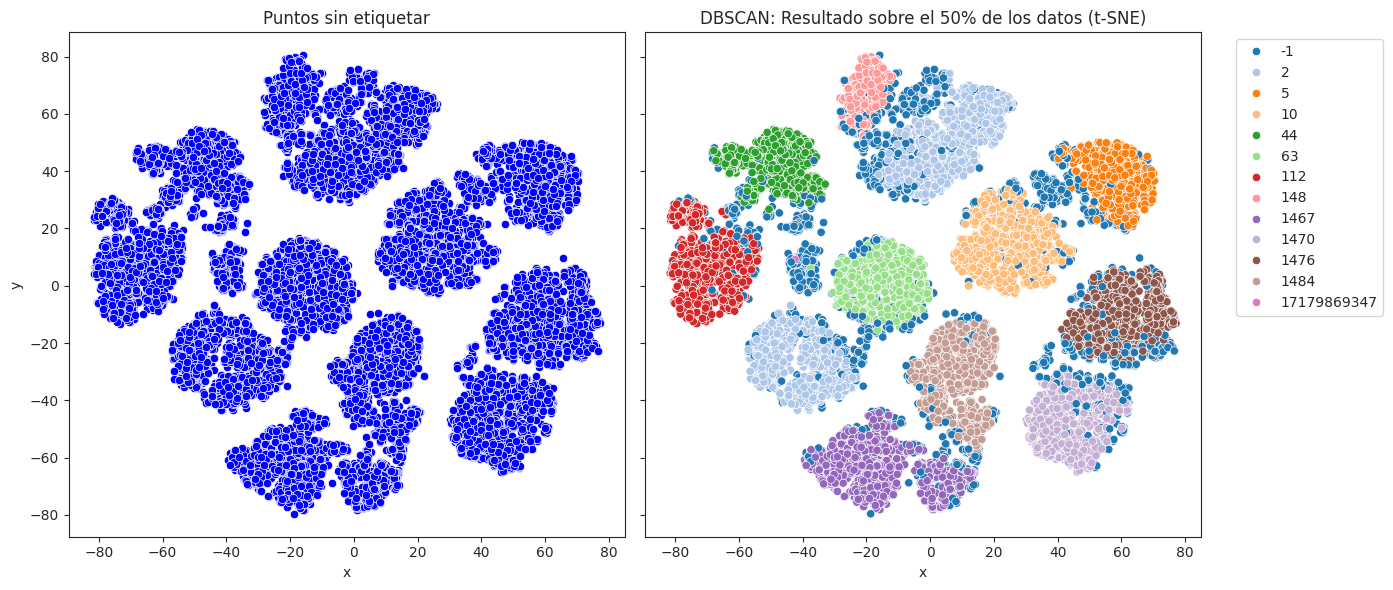

In [48]:
plot_result(X_tsne, df_results["component"], title="DBSCAN: Resultado sobre el 50% de los datos (t-SNE)")

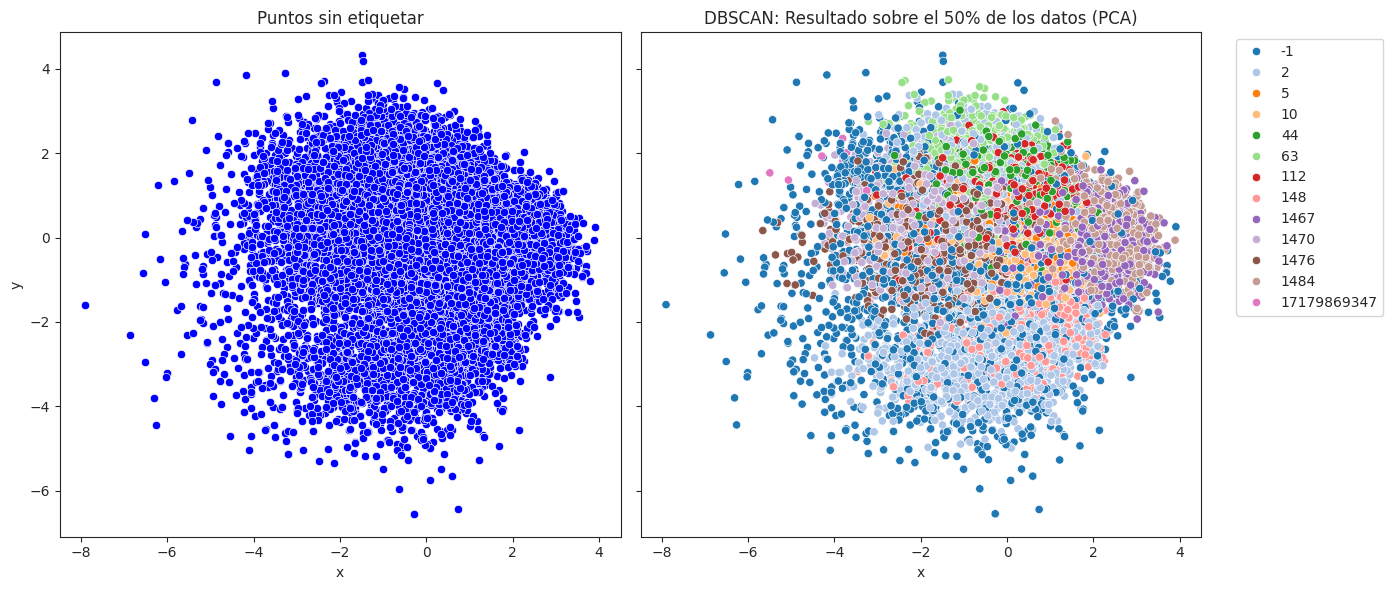

In [49]:
plot_result(df_results[['pca1', 'pca2']], df_results["component"], title="DBSCAN: Resultado sobre el 50% de los datos (PCA)")

In [50]:
df_subgeneros = df_var_saved.toPandas()
df_etiq_subgeneros = pd.merge(df_subgeneros, df_results, on='id')
print(df_etiq_subgeneros.head(5))

   id playlist_genre playlist_subgenre  \
0   1            pop        electropop   
1   2           rock    permanent wave   
2   3           rock        album rock   
3   4           rock        album rock   
4   5            pop   indie poptimism   

                                               value  component      pca1  \
0  [1.6615186744633719, -0.10257678442590903, 0.3...         -1  1.661519   
1  [1.0301788441414328, -1.6876705671596117, -1.5...          2  1.030179   
2  [-4.314419781541641, -2.5092536337125915, 1.06...         -1 -4.314420   
3  [-0.042713691477976615, -1.586806760538528, -1...          2 -0.042714   
4  [-0.6210886560872397, -0.1543577296194652, 0.4...          5 -0.621089   

       pca2      tsne1      tsne2  
0 -0.102577  43.201633  34.637497  
1 -1.687671   6.799071  60.713722  
2 -2.509254 -17.514881  37.250259  
3 -1.586807   6.570352  49.796051  
4 -0.154358  60.018635  34.362362  


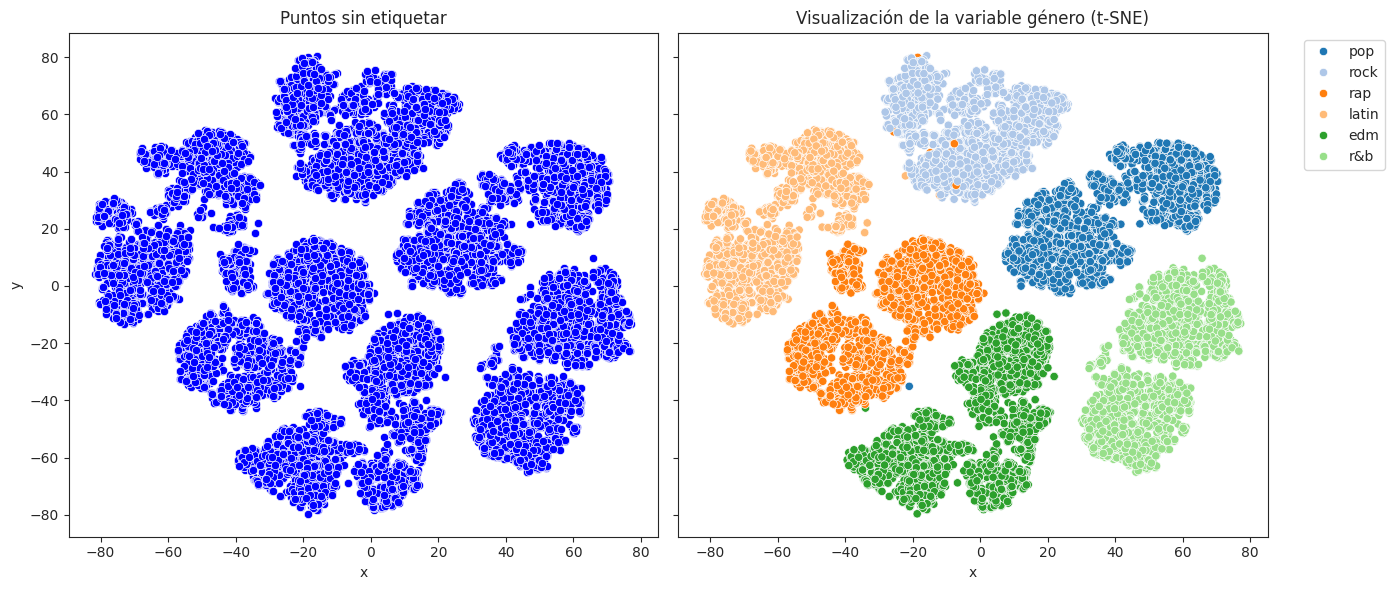

In [51]:
plot_result(df_etiq_subgeneros[['tsne1', 'tsne2']
                               ].values, df_etiq_subgeneros["playlist_genre"], title="Visualizaci√≥n de la variable g√©nero (t-SNE)")

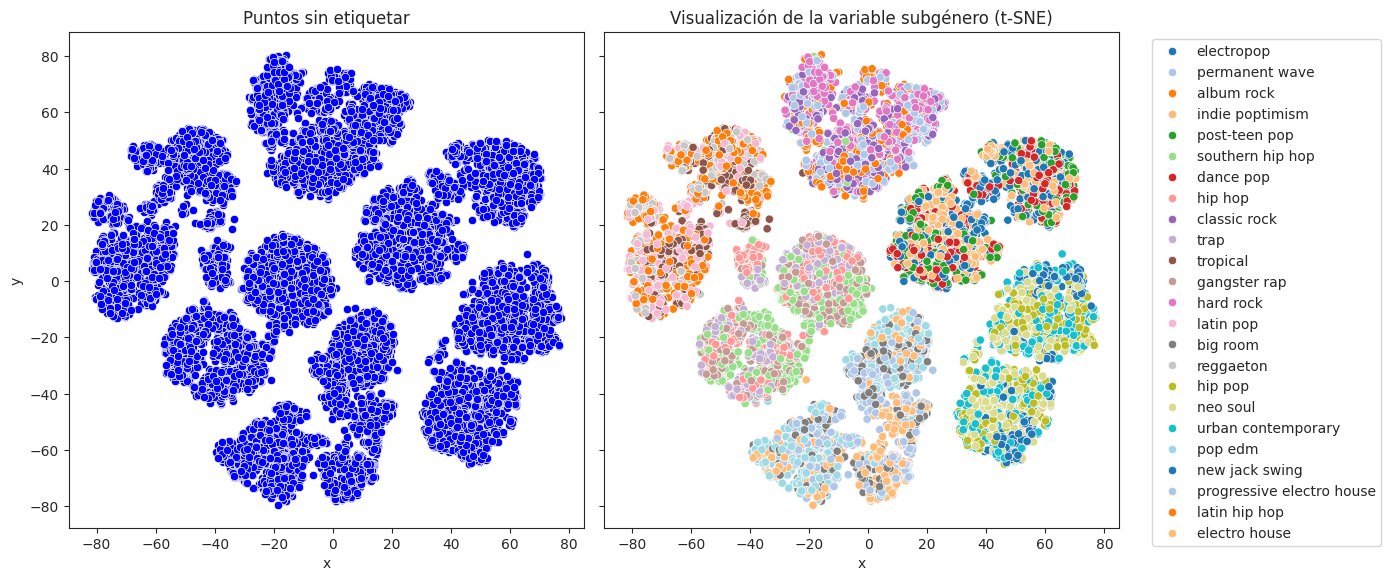

In [52]:
plot_result(df_etiq_subgeneros[['tsne1', 'tsne2']
                               ].values, df_etiq_subgeneros["playlist_subgenre"], title="Visualizaci√≥n de la variable subg√©nero (t-SNE)")

In [53]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

valores_puntos = [np.array(vec.values) for vec in df_results["value"]]

print("-------- M√©tricas para clustering --------")
print("Pseudo F: ", calinski_harabasz_score(
    valores_puntos, np.array(df_results["component"])))
print("Davies-Bouldin: ", davies_bouldin_score(valores_puntos,
      np.array(df_results["component"])))
print("Silueta: ", silhouette_score(valores_puntos,
      np.array(df_results["component"])))

-------- M√©tricas para clustering --------
Pseudo F:  808.4630000623533
Davies-Bouldin:  2.5110346005872297
Silueta:  0.045620141560863255


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=97fa435b-89c8-4b22-a4df-60f2ff3508a1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>